In [2]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Two layer neural network

## Linear layer
A neural net library with common layers and cost functions

`nn.Linear(5, 3)` creates a linear transformation ($A\cdot X+b$) of a $N \times 5$ matrix into a $N \times 3$ matrix, where N can be anything (number of observations).

In [3]:
D = 5 # number of input featutes
M = 3 # neurons in the first hidden layer
linear_map = nn.Linear(D, M)

In [4]:
# parameters are initialized randomly
[p for p in linear_map.parameters()]

[Parameter containing:
 tensor([[-0.3185,  0.3846,  0.2960, -0.1249, -0.3961],
         [ 0.0930,  0.1688, -0.4212, -0.2945, -0.1751],
         [ 0.3912, -0.2877, -0.1371,  0.2486, -0.4320]], requires_grad=True),
 Parameter containing:
 tensor([-0.1799, -0.2078,  0.3898], requires_grad=True)]

In [5]:
[p.shape for p in linear_map.parameters()]

[torch.Size([3, 5]), torch.Size([3])]

## Two layer neural network model

In [12]:
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1)
)

In [14]:
# or 
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

## Fake data for two layer NN

In [15]:
# generating fake data
# Here we generate some fake data
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def gen_nn_fake_data(n):
    x = np.random.uniform(0,10, (n, 2))
    x1 = x[:,0]
    x2 = x[:,1]
    score1 = sigmoid(-x1 - 8* x2 + 50)
    score2 = sigmoid(-7*x1 - 2* x2 + 50)
    score3 = 2* score1 + 3*score2 - 0.1
    y = score3 < 0
    return x, y.astype(int)

x, y = gen_nn_fake_data(500)

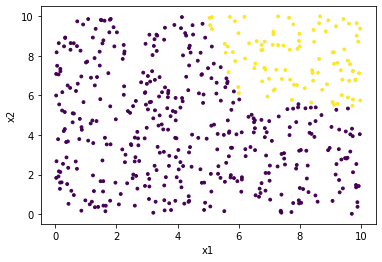

In [16]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0],x[:,1],c=y, s=8);
plt.xlabel("x1"); plt.ylabel("x2");

## Training Loop

In [25]:
x, y = gen_nn_fake_data(10000)
x = torch.tensor(x).float()
y = torch.tensor(y).float()

x_val, y_val = gen_nn_fake_data(2000)
x_val = torch.tensor(x_val).float()
y_val = torch.tensor(y_val).float()

In [30]:
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1)
)

In [31]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    model.train()
    y_hat = model(x)
    loss = F.binary_cross_entropy(torch.sigmoid(y_hat), y.unsqueeze(1))
       
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables
    optimizer.zero_grad()
    loss.backward()
    
    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    model.eval()
    y_hat_val = model(x_val)
    val_loss = F.binary_cross_entropy(torch.sigmoid(y_hat_val), y_val.unsqueeze(1))
    if t % 1000 == 0: print("train loss %.3f valid loss %.3f" % (loss.item(), val_loss.item()))

train loss 0.641 valid loss 0.572
train loss 0.112 valid loss 0.111
train loss 0.025 valid loss 0.027
train loss 0.011 valid loss 0.011
train loss 0.008 valid loss 0.008
train loss 0.006 valid loss 0.006
train loss 0.005 valid loss 0.004
train loss 0.004 valid loss 0.004
train loss 0.004 valid loss 0.003
train loss 0.003 valid loss 0.003


In [33]:
print([p for p in model.parameters()])

[Parameter containing:
tensor([[-3.9337, -1.0914],
        [ 1.0079,  8.4966]], requires_grad=True), Parameter containing:
tensor([ 28.5473, -55.4122], requires_grad=True), Parameter containing:
tensor([[-68.2421,  39.0313]], requires_grad=True), Parameter containing:
tensor([-22.6099], requires_grad=True)]


# Dataset and Data loaders 

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

In [67]:
from torch.utils.data import Dataset, DataLoader

Next we are going to create a data loader. The data loader provides the following features:
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

In [68]:
class FakeDataset(Dataset):
    def __init__(self, n=10000):
        x, y = gen_nn_fake_data(n)
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_ds = FakeDataset(10000)
valid_ds = FakeDataset(5000)

In [69]:
batch_size = 1000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [70]:
x, y = next(iter(train_dl))

In [71]:
x

tensor([[1.1602, 9.4672],
        [0.6305, 9.5441],
        [5.3423, 6.1749],
        ...,
        [0.3807, 0.5041],
        [0.4135, 7.3653],
        [3.8277, 8.4361]])

In [72]:
x.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [87]:
def valid_metric(model, valid_dl):
    model.eval()
    total_loss = 0
    total = 0
    correct = 0
    for x, y in valid_dl: 
        out = model2(x)
        loss = F.binary_cross_entropy(torch.sigmoid(out), y.unsqueeze(1))
        total_loss += loss.item()*y.shape[0]
        total += y.shape[0]
        y_pred = out > 0
        correct += (y_pred.float() == y.unsqueeze(1)).float().sum()
    return total_loss/total, correct/total

In [88]:
def train_model(model, optimizer, train_dl, valid_dl):  
    for t in range(200):
        # one epoch
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl: 
            y_hat = model2(x)
            loss = F.binary_cross_entropy(torch.sigmoid(y_hat), y.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*y.shape[0]
            total += y.shape[0] 
        train_loss = total_loss/total
        valid_loss, valid_acc = valid_metric(model, valid_dl)
        if t % 10 == 0: print("train loss %.3f valid loss %.3f valid acc %.3f" % (train_loss, valid_loss, valid_acc))

In [89]:
model2 = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1)
)
learning_rate = 0.1
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [90]:
train_model(model2, optimizer, train_dl, valid_dl)

train loss 0.492 valid loss 0.403 valid acc 0.805
train loss 0.053 valid loss 0.055 valid acc 0.983
train loss 0.040 valid loss 0.037 valid acc 0.988
train loss 0.032 valid loss 0.029 valid acc 0.991
train loss 0.030 valid loss 0.028 valid acc 0.989
train loss 0.023 valid loss 0.026 valid acc 0.990
train loss 0.020 valid loss 0.020 valid acc 0.995
train loss 0.020 valid loss 0.019 valid acc 0.994
train loss 0.021 valid loss 0.020 valid acc 0.993
train loss 0.017 valid loss 0.016 valid acc 0.995
train loss 0.014 valid loss 0.015 valid acc 0.995
train loss 0.017 valid loss 0.027 valid acc 0.985
train loss 0.029 valid loss 0.033 valid acc 0.983
train loss 0.014 valid loss 0.014 valid acc 0.996
train loss 0.020 valid loss 0.013 valid acc 0.997
train loss 0.030 valid loss 0.016 valid acc 0.994
train loss 0.012 valid loss 0.012 valid acc 0.996
train loss 0.014 valid loss 0.015 valid acc 0.992
train loss 0.013 valid loss 0.013 valid acc 0.996
train loss 0.013 valid loss 0.013 valid acc 0.995


In [91]:
print([p for p in model2.parameters()])

[Parameter containing:
tensor([[-2.0527, -0.2049],
        [ 0.1062, -2.4449],
        [ 0.1224, -1.1607],
        [-0.5163, -1.0366],
        [-0.8761, -0.9879],
        [-2.1621, -0.1937],
        [ 0.8457, -3.1322],
        [-1.7381, -0.2122],
        [-1.6616, -0.2203],
        [ 1.0245,  0.9761]], requires_grad=True), Parameter containing:
tensor([11.8168, 12.2066,  1.8464, -0.6729, 12.7491, 12.4397, 11.7366,  9.7058,
         9.1248,  1.6855], requires_grad=True), Parameter containing:
tensor([[ -9.7150, -15.1803,  -1.0264,  -0.0852, -12.5272, -11.0362,  -8.0064,
          -4.4708,  -4.7272,   8.5607]], requires_grad=True), Parameter containing:
tensor([7.3343], requires_grad=True)]


# References
* https://pytorch.org/docs/stable/index.html
* http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
* https://hsaghir.github.io/data_science/pytorch_starter/